# Fetch data from link (the github repo in this case)

# [Data set information](https://archive.ics.uci.edu/ml/datasets/Geographical+Original+of+Music)
The dataset was built from a personal collection of 1059 tracks covering 33 countries/area. The music used is traditional, ethnic or `world' only, as classified by the publishers of the product on which it appears. Any Western music is not included because its influence is global - what we seek are the aspects of music that most influence location. Thus, being able to specify a location with strong influence on the music is central.

The geographical location of origin was manually collected the information from the CD sleeve notes, and when this information was inadequate we searched other information sources. The location data is limited in precision to the country of origin.

The country of origin was determined by the artist's or artists' main country/area of residence. Any track that had ambiguous origin is not included. We have taken the position of each country's capital city (or the province of the area) by latitude and longitude as the absolute point of origin.

The program MARSYAS[1] was used to extract audio features from the wave files. We used the default MARSYAS settings in single vector format (68 features) to estimate the performance with basic timbal information covering the entire length of each track. No feature weighting or pre-filtering was applied. All features were transformed to have a mean of 0, and a standard deviation of 1. We also investigated the utility of adding chromatic attributes. These describe the notes of the scale being used. This is especially important as a distinguishing feature in geographical ethnomusicology. The chromatic features provided by MARSYAS are 12 per octave - Western tuning, but it may be possible to tell something from how similar to or different from Western tuning the music is.

[1] G. Tzanetakis and P. Cook, â€œMARSYAS: a framework for audio analysis,â€ Organised Sound, vol. 4, pp. 169â€“175, 2000. 

## Attribute Information:
* **Rows:** each row is an audio track.
* **Features or inputs:** the first 68 columns (0-67) are audio features of the track.
* **Outputs:** the last two columns (68,69) are the origin of the music, represented by latitude (68) and longitude (69).

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from random import sample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

# Read the data from github repo by url
data_url = "https://github.com/scardenol/ai_2023/blob/main/2.%20Hybrid%20supervised/Autoencoders/data/Geographical%20Original%20of%20Music/default_features_1059_tracks.txt"
data = pd.read_csv(data_url + "?raw=true", sep=",", header=None)

# Change column type
data.columns = data.columns.astype(str)
# Rename last 2 columns
data.rename(columns={'68':'latitude', '69':'longitude'}, inplace=True)
# Get inputs
inputs = data.iloc[:,:67]
outputs = data[['latitude', 'longitude']]

# Separate features (inputs) and outpus

In [ ]:
# Create the mlp class
class mlp:
    """This is the Multi Layer Perceptron class. An object of this class is an instance of a neural network
    with a shallow or a deep architecture depending on the number of hidden layers (depth) and neurons per
    hidden layer (base).
    """
    def __init__(
        self,
        inputs,
        outputs,
        validation_inputs,
        validation_outputs,
        activation=None,
        hidden_layer=None,
        learning_rate=1,
        epochs=100,
        tol=1e-2,
    ) -> None:  # sourcery skip: dict-assign-update-to-union, simplify-dictionary-update
        if activation is None:
            activation = {"input": "sigmoid", "hidden": "sigmoid", "output": "sigmoid"}
        if hidden_layer is None:
            hidden_layer = {"layers": 1, "neurons": 3}
        hidden_layer["activation"] = activation["hidden"]
        self.X = np.array(inputs)
        self.Y = np.array(outputs)
        self.validation = {
            "X_val": np.array(validation_inputs),
            "Y_val": np.array(validation_outputs),
        }
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol
        input_layer = {"neurons": inputs.shape[1], "activation": activation["input"]}
        self.layers = {"input_layer": input_layer}
        for layer in range(hidden_layer["layers"]):
            layer_name = f"hidden_layer_{str(layer)}"
            self.layers[layer_name] = {
                "neurons": hidden_layer["neurons"],
                "activation": activation["hidden"],
            }
        output_layer = {"neurons": outputs.shape[1], "activation": activation["output"]}
        self.layers.update({"output_layer": output_layer})
        layers_names = list(self.layers.keys())
        self.layers_names = layers_names
        for i in range(len(layers_names)):
            layer = layers_names[i]
            if i == 0:
                self.layers[layer]["weights"] = np.random.uniform(
                    low=-1,
                    high=1,
                    size=(self.layers[layer]["neurons"], self.layers[layer]["neurons"]),
                )
            else:
                previous = layers_names[i - 1]
                self.layers[layer]["weights"] = np.random.uniform(
                    low=-1,
                    high=1,
                    size=(
                        self.layers[previous]["neurons"],
                        self.layers[layer]["neurons"],
                    ),
                )
        self.validation["layers"] = self.layers

    def phi(self, x, activation):
        """This is the activation function applied to all the neurons of a specific layer.

        Args:
            x (np.array): a number, vector or array of numbers.
            activation (str): a string with the name of the desired activation function.

        Returns:
            np.array: the resulting transformation of the input data object x.
        """
        if activation == "sigmoid":
            return 1 / (1 + np.exp(-x))
        elif activation == "tanh":
            return np.tanh(x)
        elif activation == "relu":
            return np.maximum(0, x)

    def dphi(self, x, activation):
        """This is the derivate of the activation function applied to all the neurons of a specific layer.

        Args:
            x (np.array): a number, vector or array of numbers.
            activation (str): a string with the name of the desired activation function.

        Returns:
            np.array: the resulting transformation of the input data object x.
        """
        if activation == "sigmoid":
            return x * (1 - x)
        elif activation == "tanh":
            return 1 - np.tanh(x) ** 2
        elif activation == "relu":
            return (x > 0) * 1

    def e(self, d, y):
        """The error function, defined as the difference between the desired (or expected) and real d - y.

        Args:
            d (np.array): the desired vector.
            y (np.array): the real vector.

        Returns:
            np.array: the error vector.
        """
        if np.shape(d) != np.shape(y):
            d = np.reshape(d, newshape=y.shape)
        return d - y

    def E(self, e):
        """The instantaneous energy error, it measures the lack of effectiveness for each neuron in a
        specific layer.

        Args:
            e (np.array): the error vector.

        Returns:
            np.array: the instantaneous energy vector.
        """
        return 0.5 * (sum(e**2))

    def E_av(self, E):
        """The average instantaneous energy error, it measures the complete network error which makes it the
        loss function. The goal is to find the weights that minimize this average error of estimation.

        Args:
            E (np.array): the instantaneous energy vector.

        Returns:
            float: the complete network error of estimation.
        """
        return np.mean(E)

    def forward_pass(self):
        """Calculates the output for each layer. This is the first step and the results are needed for
        the backward pass.
        """
        for i in range(len(self.layers_names)):
            layer = self.layers_names[i]
            if i == 0:  # input layer
                self.layers[layer]["local_field"] = np.dot(
                    self.X, self.layers[layer]["weights"]
                )
            else:  # other layers
                previous = self.layers_names[i - 1]
                self.layers[layer]["local_field"] = np.dot(
                    self.layers[previous]["output"], self.layers[layer]["weights"]
                )
            self.layers[layer]["output"] = self.phi(
                self.layers[layer]["local_field"], self.layers[layer]["activation"]
            )

    def backward_pass(self):
        """This method is the backpropagation without updating the weights, hence its name
        backward pass. It calculates the local gradients in reverse from the output to the input layer.
        """
        # Backpropagation
        for i in reversed(range(len(self.layers_names))):
            layer = self.layers_names[i]
            if i == len(self.layers_names) - 1:  # output layer
                error = self.e(self.Y, self.layers[layer]["output"])
                energy_error = self.E(error)
                self.network_error = np.append(
                    self.network_error, self.E_av(energy_error)
                )
                self.layers[layer]["error"] = error
            else:  # other layers
                previous = self.layers_names[i + 1]
                error = self.layers[previous]["local_gradient"].dot(
                    self.layers[previous]["weights"].T
                )
            local_gradient = error * self.dphi(
                self.layers[layer]["output"], self.layers[layer]["activation"]
            )
            self.layers[layer]["local_gradient"] = local_gradient
        self.delta_k = np.append(
            self.delta_k, np.mean(self.layers["output_layer"]["local_gradient"])
        )

    def update_weights(self):
        """This method is the last part of backpropagation, where the classical gradient
        descent algorithm its used to update the weights.
        """
        # update weights using gradient descent
        for i in range(len(self.layers_names)):
            layer = self.layers_names[i]
            w = self.layers[layer]["weights"]
            if i == 0:  # input layer
                dw = self.X.T.dot(self.layers[layer]["local_gradient"])
            else:
                previous = self.layers_names[i - 1]
                dw = self.layers[previous]["output"].T.dot(
                    self.layers[layer]["local_gradient"]
                )
            w += self.learning_rate * dw
            self.layers[layer]["weights"] = w

    def validate(self):
        """This is the validation method. Here the validation set its used to perform
        a forward pass of the network, then a backward pass to the output layer
        calculating only the output local gradient and the network error.
        This method doesn't perform weights updates and does not interfere with the training
        of the network. 
        """

        # Forward pass with validation input
        for i in range(len(self.layers_names)):
            layer = self.layers_names[i]
            if i == 0:  # input layer
                self.validation["layers"][layer]["local_field"] = np.dot(
                    self.validation["X_val"],
                    self.validation["layers"][layer]["weights"],
                )
            else:  # other layers
                previous = self.layers_names[i - 1]
                self.validation["layers"][layer]["local_field"] = np.dot(
                    self.validation["layers"][previous]["output"],
                    self.validation["layers"][layer]["weights"],
                )
            self.validation["layers"][layer]["output"] = self.phi(
                self.validation["layers"][layer]["local_field"],
                self.validation["layers"][layer]["activation"],
            )

        # Backward pass only to calculate the network error and output gradient with validation set
        layer = "output_layer"
        error = self.e(
            self.validation["Y_val"], self.validation["layers"][layer]["output"]
        )
        energy_error = self.E(error)
        self.validation["network_error"] = np.append(
            self.validation["network_error"], self.E_av(energy_error)
        )
        self.validation["layers"][layer]["error"] = error
        local_gradient = error * self.dphi(
            self.validation["layers"][layer]["output"],
            self.validation["layers"][layer]["activation"],
        )
        self.validation["layers"][layer]["local_gradient"] = local_gradient
        self.validation["delta_k"] = np.append(
            self.validation["delta_k"],
            np.mean(self.validation["layers"][layer]["local_gradient"]),
        )

    def learn(self, print_progress=False):
        """This is the main method. In here the learning process its performed on the
        training set and evaluated on the validation set. The main desired results are collected here.

        Args:
            print_progress (bool, optional): An optional parameter to flag
            whether the user wants to print the progress of the network learning
            or not. Defaults to False.
        """
        self.network_error = []
        self.delta_k = []
        self.validation["network_error"] = []
        self.validation["delta_k"] = []
        for epoch in range(self.epochs):
            self.forward_pass()
            self.backward_pass()
            if self.network_error[-1] < self.tol:
                break
            self.update_weights()
            self.validate()
            if print_progress:
                print("epoch =", epoch, "error =", self.network_error[-1])
        if print_progress:
            print(
                "desired:\n", self.Y, "real:\n", self.layers["output_layer"]["output"]
            )

    def getCode(self, X):
      for i in range(len(self.layers_names)-1):
            layer = self.layers_names[i]
            if i == 0:  # input layer
                X = np.dot(X, self.layers[layer]["weights"]
                )
            else:  # other layers
                previous = self.layers_names[i - 1]
                X = np.dot(self.layers[previous]["output"], self.layers[layer]["weights"])

            X = self.phi(X, self.layers[layer]["activation"])
      return X

    def predict(self, X_test, Y_test):
        """The method to make predictions. This method is created to make
        a forward pass of the trained and validated network and predict the output
        based on a test set.

        Args:
            X_test (array): input features of the test set.
            Y_test (array): outputs of the test set.
        """
        self.test = {"X_test": np.array(X_test), "Y_test": np.array(Y_test)}
        self.test["layers"] = self.layers

        # Make a forward pass to calculate the network output with the current data
        for i in range(len(self.layers_names)):
            layer = self.layers_names[i]
            if i == 0:  # input layer
                self.test["layers"][layer]["local_field"] = np.dot(
                    self.test["X_test"],
                    self.test["layers"][layer]["weights"],
                )
            else:  # other layers
                previous = self.layers_names[i - 1]
                self.test["layers"][layer]["local_field"] = np.dot(
                    self.test["layers"][previous]["output"],
                    self.test["layers"][layer]["weights"],
                )
            self.test["layers"][layer]["output"] = self.phi(
                self.test["layers"][layer]["local_field"],
                self.test["layers"][layer]["activation"],
            )
        self.test["Y_hat"] = self.test["layers"]["output_layer"]["output"]



In [ ]:
# Read the data and sample the desired amount of observations
X = inputs.values
Y = outputs.values

# Normalize both the input features and the output data to [0,1]
X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))

# Define a split data function for the train-validation-test split
def splitData(X, d, per=[0.6, 0.2, 0.2]):
    n = X.shape[0]
    splits = np.cumsum([int(i*n) for i in per])
    idx = sample(range(n), n)
    #idx = range(n)
    idx_train = idx[0:splits[0]]
    idx_val = idx[splits[0]:splits[1]]
    idx_test = idx[splits[1]:splits[2]]
    

    X_train = X[idx_train, :]
    X_val = X[idx_val, :]
    X_test = X[idx_test, :]
    d_train = d[idx_train]
    d_val = d[idx_val]
    d_test = d[idx_test]
    return X_train, d_train, X_val, d_val, X_test, d_test, idx


# Split data into train (60%), validation (20%) y test (20%)
X_train, Y_train, X_validation, Y_validation, X_test, Y_test, _ = splitData(X, Y, per=[0.6, 0.2, 0.2])

In [ ]:
def runPlease(X_train, Y_train, X_validation, Y_validation,
              L, li_min, li_max, li_step, learning_rate, n_epochs,
              name=None):
  # Variables to collect and store results
  networks_errors = {}
  networks_errors_val = {}
  parameters = {}
  deltas_k = {}
  deltas_k_val = {}
  y_hats = {}
  models = {}
  # Then main experiment cycle: iterate over base, learning rate and depth
  nns = []
  for L in range(1, L + 1):
      for lr in learning_rate:
          for li in range(li_min, li_max+1, li_step):
              p = mlp(
                  inputs = X_train,
                  outputs = Y_train,
                  validation_inputs = X_validation,
                  validation_outputs = Y_validation,
                  epochs=n_epochs,
                  hidden_layer={"layers": L, "neurons": li},
                  learning_rate=lr,
                  tol=1e-2,
              )
              p.learn(print_progress=False)
              model = f"L = {L}, li = {li}, lr = {lr}"
              networks_errors[model] = p.network_error
              networks_errors_val[model] = p.validation["network_error"]
              parameters[model] = X_train.shape[1] * L * li * Y_train.shape[1]
              deltas_k[model] = p.delta_k
              deltas_k_val[model] = p.validation["delta_k"]
              p.predict(X_test, Y_test)
              nns.append(p)

              y_hats[model] = p.test["Y_hat"]
      models[f"layer_{L}"] = {
          "networks_errors": networks_errors,
          "networks_errors_val": networks_errors_val,
          "parameters": parameters,
          "deltas_k": deltas_k,
          "deltas_k_val": deltas_k_val,
          "y_hats": y_hats,
      }
      models[f"layer_{L}"]["names"] = list(models[f"layer_{L}"]["networks_errors"].keys())
      networks_errors = {}
      networks_errors_val = {}
      parameters = {}
      deltas_k = {}
      deltas_k_val = {}

  # Manage the results, apply the selection criterion, plot and save

  # Create the Figs folder to store the plots or skip if it exists
  os.makedirs(
      "Figs", exist_ok=True
  ) 

  # For each layer use the results, select the best, worst and median model and plot all the results
  for layer in models:
      networks_errors = models[layer]["networks_errors"]
      parameters = models[layer]["parameters"]
      deltas_k = models[layer]["deltas_k"]
      networks_errors_val = models[layer]["networks_errors_val"]
      deltas_k_val = models[layer]["deltas_k_val"]

      # Sort by last network_error (lowest-largest) in validation set
      sort1 = dict(sorted(networks_errors_val.items(), key=lambda x: x[1][-1]))
      sort2 = sort1
      sort2_list = list(sort2.items())

      best = sort2_list[0][0]
      worst = sort2_list[-1][0]
      median = sort2_list[len(sort2_list) // 2 - 1][0]

      # Plot training results
      my_dpi = 96  # My screen DPI
      my_width = 1366  # Desired width resolution
      my_length = 655  # Desired length resolution

      # title = f"Training for ANN with L = {layer[-1]}"
      # fig, ax = plt.subplots(
      #     1, 2, num=title, figsize=(my_width / my_dpi, my_length / my_dpi), dpi=my_dpi
      # )
      # fig.suptitle(title)
      # ax[0].plot(networks_errors[best], ".-", label=f"best: {best}")
      # ax[0].plot(networks_errors[worst], ".-", label=f"worst: {worst}")
      # ax[0].plot(networks_errors[median], ".-", label=f"median: {median}")
      # ax[0].grid()
      # ax[0].legend()
      # ax[0].set_title(r"Network error $\mathcal{E}_{av}$ over epochs")
      # ax[0].set_xlabel("Epochs")
      # ax[0].set_ylabel(r"$\mathcal{E}_{av}$")

      # ax[1].plot(deltas_k[best], ".-", label=f"best: {best}")
      # ax[1].plot(deltas_k[worst], ".-", label=f"worst: {worst}")
      # ax[1].plot(deltas_k[median], ".-", label=f"median: {median}")
      # ax[1].grid()
      # ax[1].legend()
      # ax[1].set_title(r"Average output gradient $\bar{\delta}_k$ over epochs")
      # ax[1].set_xlabel("Epochs")
      # ax[1].set_ylabel(r"$\bar{\delta}_k$")
      # plt.savefig(f'Figs/{title.replace(" ", "_")}.png')
      # plt.show(block=False)

      # Plot validation results
      title = f"Validation for ANN with L = {layer[-1]}"
      fig, ax = plt.subplots(
          2, 1, num=title, figsize=(my_length / my_dpi, my_width / my_dpi), dpi=my_dpi
      )
      fig.suptitle(title)
      ax[0].plot(networks_errors_val[best], ".-", label=f"best: {best}")
      ax[0].plot(networks_errors_val[worst], ".-", label=f"worst: {worst}")
      ax[0].plot(networks_errors_val[median], ".-", label=f"median: {median}")
      ax[0].grid()
      ax[0].legend()
      ax[0].set_title(r"Network error $\mathcal{E}_{av}$ over epochs")
      ax[0].set_xlabel("Epochs")
      ax[0].set_ylabel(r"$\mathcal{E}_{av}$")

      ax[1].plot(deltas_k_val[best], ".-", label=f"best: {best}")
      ax[1].plot(deltas_k_val[worst], ".-", label=f"worst: {worst}")
      ax[1].plot(deltas_k_val[median], ".-", label=f"median: {median}")
      ax[1].grid()
      ax[1].legend()
      ax[1].set_title(r"Average output gradient $\bar{\delta}_k$ over epochs")
      ax[1].set_xlabel("Epochs")
      ax[1].set_ylabel(r"$\bar{\delta}_k$")
      plt.savefig(f'Figs/{name}.png')
      plt.show(block=False)

      pp = []
      for key in models.keys():
        for elem in models[key]['names']:
          pp.append(elem)

      idx_best = [i for i, elem in enumerate(pp) if elem==best][0]
      nn_best = nns[idx_best]
      return nns, nn_best

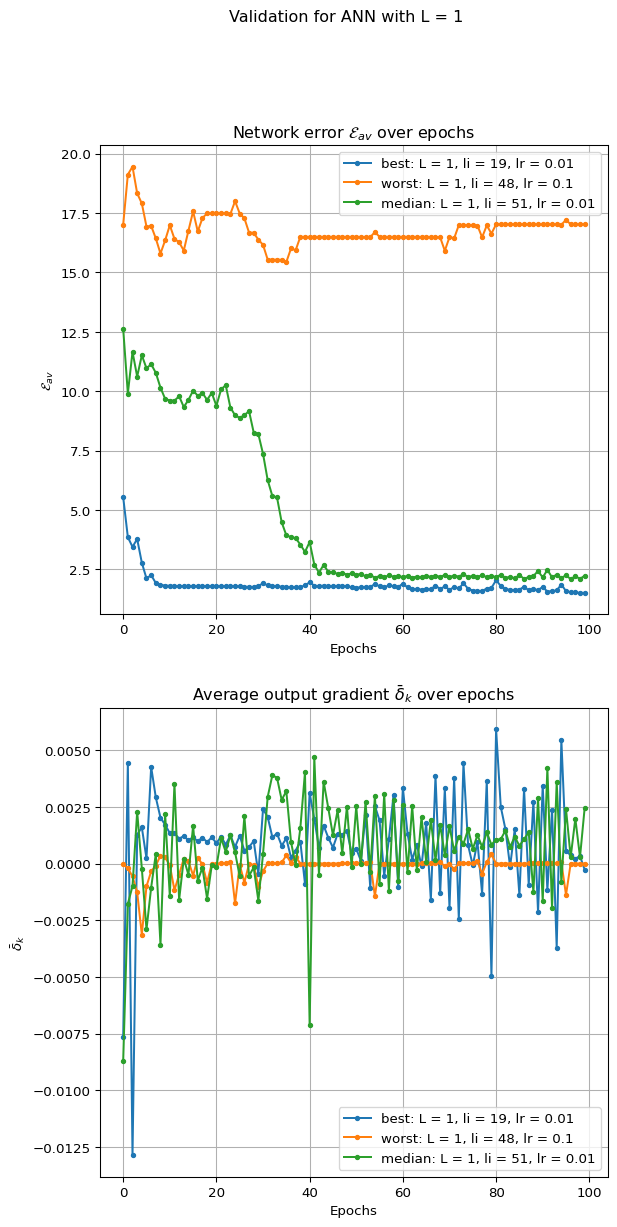

In [ ]:
# Reduction of dimensionality.

np.random.seed(1)

# General parameters
L = 1  # Max number of hidden layers
li_min = 1  # Max number of neurons per hidden layer
li_max = 67  # Max number of neurons per hidden layer
li_step = 1  # Max number of neurons per hidden layer
learning_rate = [0.001, 0.01, 0.1]  # Learning rates
n_epochs = 100

nns, nn_best_reduction = runPlease(X_train, X_train, X_validation, X_validation, L,
          li_min, li_max, li_step, learning_rate, n_epochs, 'val_reduction')

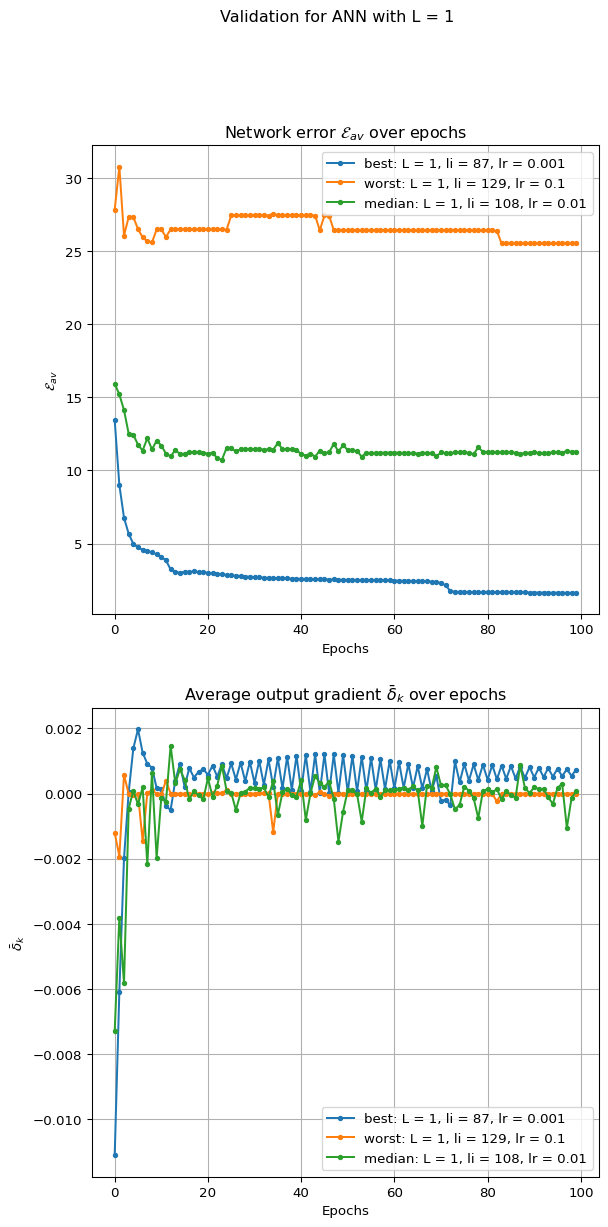

In [ ]:
# Feature extraction.
np.random.seed(1)

# General parameters
L = 1  # Max number of hidden layers
li_min = 68  # Max number of neurons per hidden layer
li_max = 2*68  # Max number of neurons per hidden layer
li_step = 1  # Max number of neurons per hidden layer
learning_rate = [0.001, 0.01, 0.1]  # Learning rates
n_epochs = 100

nns, nn_best_feature = runPlease(X_train, X_train, X_validation, X_validation, L,
          li_min, li_max, li_step, learning_rate, n_epochs, 'val_feauteExtraction')

In [ ]:
# # Best
# np.random.seed(1)

# # General parameters
# L = 5  # Max number of hidden layers
# li_min = 1  # Max number of neurons per hidden layer
# li_max = 5  # Max number of neurons per hidden layer
# li_step = 1  # Max number of neurons per hidden layer
# learning_rate = [0.001, 0.1, 0.01]  # Learning rates
# n_epochs = 100

# nns, nn_best = runPlease(X_train, Y_train, X_validation, Y_validation, L,
#           li_min, li_max, li_step, learning_rate, n_epochs)

In [ ]:
def plot_validation(y_trues, y_preds, name=None):
  for feature in range(y_trues.shape[1]):
    y_true = y_trues[:,feature]
    y_pred = y_preds[:,feature]
    fig = plt.figure()
    plt.grid()
    plt.plot(y_true, y_pred, 'o')

    lb = np.min(np.vstack([y_true, y_pred]))
    ub = np.max(np.vstack([y_true, y_pred]))
    plt.ylim([lb, ub])
    plt.xlim([lb, ub])
    plt.xlabel('True y')
    plt.ylabel('Prediction y')
    plt.title(f'Output {feature}')
    plt.savefig(f'OutputTest_{name}_{feature}.jpeg', dpi=1200)
    plt.show()


def MLP_keras(X, Y):
  # Set the input shape
  input_shape = (X.shape[1],)
  print(f'Feature shape: {input_shape}')

  # Create the model
  model = Sequential()
  model.add(Dense(3, input_shape=input_shape, activation='sigmoid'))
  model.add(Dense(Y.shape[1], activation='sigmoid'))

  # Configure the model and start training
  model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['mean_squared_error'])
  model.fit(X, Y, epochs=500, batch_size=50, verbose=1, validation_split=0.2)
  return model

def instantEnergy(X, model, y_true):
  return 0.5 * np.sum(np.power(model.predict(X) - y_true, 2))

Feature shape: (19,)
Epoch 1/500
4/4 [==============================] - 1s 66ms/step - loss: 0.1193 - mean_squared_error: 0.0262 - val_loss: 0.1030 - val_mean_squared_error: 0.0207
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 0.1132 - mean_squared_error: 0.0254 - val_loss: 0.0970 - val_mean_squared_error: 0.0202
Epoch 3/500
4/4 [==============================] - 0s 19ms/step - loss: 0.1116 - mean_squared_error: 0.0255 - val_loss: 0.0944 - val_mean_squared_error: 0.0201
Epoch 4/500
4/4 [==============================] - 0s 12ms/step - loss: 0.1122 - mean_squared_error: 0.0260 - val_loss: 0.0949 - val_mean_squared_error: 0.0204
Epoch 5/500
4/4 [==============================] - 0s 14ms/step - loss: 0.1127 - mean_squared_error: 0.0263 - val_loss: 0.0948 - val_mean_squared_error: 0.0204
Epoch 6/500
4/4 [==============================] - 0s 13ms/step - loss: 0.1122 - mean_squared_error: 0.0261 - val_loss: 0.0943 - val_mean_squared_error: 0.0201
Epoch 7/500
4/4 [==

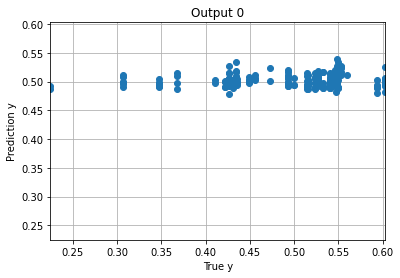

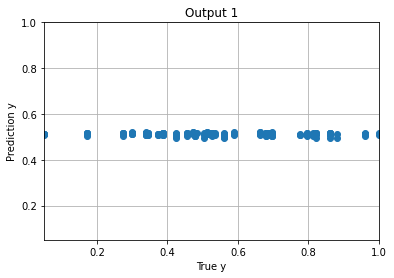

In [ ]:
X_train_reduction = nn_best_reduction.getCode(X_train)
model_reduction = MLP_keras(X_train_reduction, Y_train)
X_test_reduction = nn_best_reduction.getCode(X_test)
plot_validation(Y_test, model_reduction.predict(X_test_reduction), 'reduction')

Feature shape: (87,)
Epoch 1/500
4/4 [==============================] - 1s 55ms/step - loss: 0.2540 - mean_squared_error: 0.0829 - val_loss: 0.1412 - val_mean_squared_error: 0.0333
Epoch 2/500
4/4 [==============================] - 0s 13ms/step - loss: 0.1383 - mean_squared_error: 0.0335 - val_loss: 0.0968 - val_mean_squared_error: 0.0207
Epoch 3/500
4/4 [==============================] - 0s 12ms/step - loss: 0.1111 - mean_squared_error: 0.0256 - val_loss: 0.1005 - val_mean_squared_error: 0.0201
Epoch 4/500
4/4 [==============================] - 0s 18ms/step - loss: 0.1133 - mean_squared_error: 0.0252 - val_loss: 0.1030 - val_mean_squared_error: 0.0201
Epoch 5/500
4/4 [==============================] - 0s 20ms/step - loss: 0.1142 - mean_squared_error: 0.0252 - val_loss: 0.1037 - val_mean_squared_error: 0.0202
Epoch 6/500
4/4 [==============================] - 0s 13ms/step - loss: 0.1144 - mean_squared_error: 0.0252 - val_loss: 0.1035 - val_mean_squared_error: 0.0202
Epoch 7/500
4/4 [==

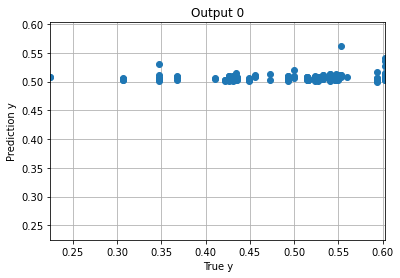

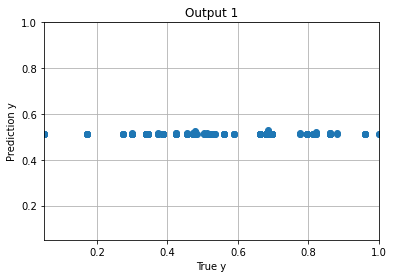

7/7 [==============================] - 0s 2ms/step
Reduction
Average energy:5.487166205214327
7/7 [==============================] - 0s 2ms/step
Feature
Average energy:5.4412415813856345


In [ ]:
X_train_feature = nn_best_feature.getCode(X_train)
model_feature = MLP_keras(X_train_feature, Y_train)
X_test_feature = nn_best_feature.getCode(X_test)
plot_validation(Y_test, model_feature.predict(X_test_feature), 'feature')

print(f'Reduction\nAverage energy:{instantEnergy(X_test_reduction, model_reduction, Y_test)}')

print(f'Feature\nAverage energy:{instantEnergy(X_test_feature, model_feature, Y_test)}')